In [74]:
import tensorflow as tf
from keras.models import load_model
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy.random import random
from numpy import vstack
import numpy as np
from numpy.random import rand 
from keras.datasets.cifar10 import load_data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
def prepare_cifar_data():
  (train_x, train_y), (test_x, test_y) = load_data()
  x = train_x.astype("float32") 
  x = (x - 127.5) / 127.5
  return x

In [76]:
prepare_cifar_data().shape

(50000, 32, 32, 3)

In [77]:
def discriminator_model(input_shape=(32,32,3)):
  model = Sequential()
  model.add(Conv2D(64,(3,3),padding="same",input_shape=input_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(3,3),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(3,3),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(256,(3,3),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation="sigmoid"))
  optimizer= Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])
  return model
  

In [78]:
discriminator_model().summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_89 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_90 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_91 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 4, 4, 256)       

In [79]:
def generate_real_samples(dataset, n_samples):
  index = randint(0, dataset.shape[0], n_samples)
  x = dataset[index]
  y = np.ones((n_samples,1))
  return x,y

In [80]:
def generator_model(latent_dim):
  model = Sequential()
  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes, input_dim = latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))
  # upsample to 8x8
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(3,(3,3), activation="tanh",padding="same"))
  return model

In [81]:
generator_model(100).summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_93 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_40 (Conv2DT (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_94 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_41 (Conv2DT (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_95 (LeakyReLU)   (None, 16, 16, 128)     

In [82]:
def generate_latent_points(latent_dim, n_samples):
  x = randn(latent_dim * n_samples)
  x = x.reshape(n_samples,latent_dim)
  return x


In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
  latent_points = generate_latent_points(latent_dim, n_samples)
  x_fake = generator.predict(latent_points)
  y = np.zeros((n_samples,1))
  return x_fake,y


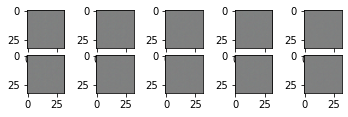

In [ ]:
# Generating fake samples from untrained generator
latent_dim = 100
generator = generator_model(100)
x, _ = generate_fake_samples(generator, latent_dim, 49)
x = (x+1)/2.0
for i in range(10):
  plt.subplot(5,5,1+i)
  plt.imshow(x[i])
plt.show()



In [ ]:
def gan_model(generator, discriminator):
  discriminator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  optimizer = Adam(learning_rate=0.0002, beta_1 = 0.5)
  model.compile(loss="binary_crossentropy", optimizer = optimizer)
  return model


In [ ]:
#gan_model = gan_model(generator, discriminator)
#gan_model.summary()

In [ ]:
def summarize_model_performance(epoch, generator, discriminator,dataset,latent_dim,n_samples=150):
  x_real, y_real = generate_real_samples(dataset,n_samples)
  _, real_accuracy = discriminator.train_on_batch(x_real, y_real)
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
  _, fake_accuracy = discriminator.train_on_batch(x_fake, y_fake)
  print("Real accuracy is " + str(real_accuracy) + " Fake accuracy is " + str(fake_accuracy))
  x_fake = (x_fake+1) / 2.0
  for j in range(5*5):
    plt.subplot(5,5,j+1)
    plt.axis("off")
    plt.imshow(x_fake[i])
  file_name = "generated_plot_e%03d.png" % (epoch+1)
  plt.savefig(file_name)
  plt.close()
  model_name = "generator_model_%03d.h5" % (epoch+1)
  generator.save(model_name)

In [ ]:
def train_gan(gan_model, generator, discriminator,latent_dim, dataset, n_epochs=200, n_batch=128):
  batches_per_epoch = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(batches_per_epoch):
      x_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1,_ = discriminator.train_on_batch(x_real,y_real)
      x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
      d_loss2, _ = discriminator.train_on_batch(x_fake, y_fake)
      x_gan = generate_latent_points(latent_dim,n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      print("Epoch "+ str(i+1) + " Batch " + str(j+1) + " Loss on real " + str(d_loss1) + " Loss on fake " + str(d_loss2 ))
    if (i+1) %5 == 0 :
      summarize_model_performance(i, generator, discriminator, dataset, latent_dim)



/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


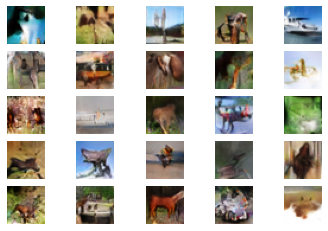

In [105]:
generator = load_model("generator_model_110.h5")
latent_points = generate_latent_points(100,50)
x = generator.predict(latent_points)
x = (x+1) / 2.0
for i in range(5*5):
  plt.subplot(5,5,i+1)
  plt.axis("off")
  plt.imshow(x[i,:,:])
plt.show()

(50, 32, 32, 3)